In [1]:
!ls

abin				   handshake-airdrop  rockland_stats.ipynb
@add_rcran_ubuntu_18.04.tcsh	   mind		      snap
bin				   Music	      temp
breath.txt			   pcasl.txt	      Templates
data-2020-03-04T22_18_22.934Z.csv  Pictures	      @update.afni.binaries
Desktop				   Public	      @update_rcran.R
Documents			   R		      Videos
Downloads			   redcap.ipynb


In [150]:
import pickle
import pandas as pd
import numpy as np
import boto3
import botocore
from IPython.display import clear_output

In [33]:
def get_all_s3_keys(**kwargs):
    keys = []
    while True:
        resp = s3.list_objects_v2(**kwargs)
        if 'Contents' in resp:
            for obj in resp['Contents']:
                keys.append(obj['Key'])
        try:
            kwargs['ContinuationToken'] = resp['NextContinuationToken']
        except KeyError:
            break
    return keys

In [22]:
df = pd.read_csv('data-2020-03-04T22_18_22.934Z.csv')

In [28]:
def convert(c, d):
    def cc(v):
        try:
            return c(v)
        except:
            return d
    return cc

df['participant'] = df.Identifiers.apply(lambda r: r.split(',')[0].strip())
df['session'] = df.Identifiers.apply(lambda r: r.split(',')[1].strip())
df['age'] = df.age_04.apply(lambda f: float(f) if f != '.' else 0.0)
df['sex'] = df.dem_002.apply(convert(lambda x: {'1': 'M', '2': 'F'}[x], np.nan))

In [129]:
df['height'] = df.height_01.apply(lambda f: float(f) if f != '.' else 0.0)
df['weight'] = df.weight_01.apply(lambda f: float(f) if f != '.' else 0.0)
df['v02max'] = df.v02max.apply(lambda f: float(f) if f != '.' else 0.0)

In [35]:
s3 = boto3.client('s3')

In [36]:
objs = get_all_s3_keys(Bucket='fcp-indi', Prefix='data/Projects/RocklandSample/RawDataBIDSLatest')

In [61]:
subject_files = list(filter(lambda x: x.startswith('data/Projects/RocklandSample/RawDataBIDSLatest/sub-'), objs))
subject_files = [s[47:] for s in subject_files]

In [65]:
# 3D MP-RAGE
# rs fMRI
# DTI
# Cerebral Blood Flow
# Breath Hold ASL
# Perfusion ASL
# Both Breath Hold & Perfusion ASL

def has_anat(r):
    return f'sub-{r.participant}/ses-{r.session}/anat/sub-{r.participant}_ses-{r.session}_T1w.nii.gz' in subject_files

def has_rest(r):
    return f'sub-{r.participant}/ses-{r.session}/func/sub-{r.participant}_ses-{r.session}_task-rest_acq-1400_bold.nii.gz' in subject_files

def has_dti(r):
    return f'sub-{r.participant}/ses-{r.session}/dwi/sub-{r.participant}_ses-{r.session}_dwi.nii.gz' in subject_files

def has_asl(r):
    return f'sub-{r.participant}/ses-{r.session}/func/sub-{r.participant}_ses-{r.session}_task-pCASL_bold.nii.gz' in subject_files

def has_breathhold(r):
    return f'sub-{r.participant}/ses-{r.session}/func/sub-{r.participant}_ses-{r.session}_task-BREATHHOLD_acq-1400_bold.nii.gz' in subject_files

df['anat'] = df.apply(has_anat, axis=1)
df['rest'] = df.apply(has_rest, axis=1)
df['dti'] = df.apply(has_dti, axis=1)
df['asl'] = df.apply(has_asl, axis=1)
df['breathhold'] = df.apply(has_breathhold, axis=1)

In [88]:
checks = ['anat', 'rest', 'dti', 'asl', 'breathhold']

In [119]:
def print_stats(df):
    print(f"{np.sum(df.anat)}\t{np.sum(df[df.sex == 'M'].anat)}\t{np.sum(df[df.sex == 'F'].anat)}")
    print(f"{np.sum(df.rest)}\t{np.sum(df[df.sex == 'M'].rest)}\t{np.sum(df[df.sex == 'F'].rest)}")
    print(f"{np.sum(df.dti)}\t{np.sum(df[df.sex == 'M'].dti)}\t{np.sum(df[df.sex == 'F'].dti)}")
    print()
    print(f"{np.sum(df.asl)}\t{np.sum(df[df.sex == 'M'].asl)}\t{np.sum(df[df.sex == 'F'].asl)}")
    print(f"{np.sum(df.breathhold)}\t{np.sum(df[df.sex == 'M'].breathhold)}\t{np.sum(df[df.sex == 'F'].breathhold)}")
    print(f"{np.sum((df.asl & df.breathhold))}\t{np.sum((df.asl & df.breathhold)[df.sex == 'M'])}\t{np.sum((df.asl & df.breathhold)[df.sex == 'F'])}")
    print("------------------------------")

In [121]:
sdf = df \
    [['participant', 'sex'] + checks] \
    .groupby('participant') \
    .agg({
        **{c: lambda x: np.sum(x.values, dtype=bool) for c in checks},
        'sex': 'max'
    })

print_stats(sdf)

sdf = df \
    [(df.age > 25) & df.session.str.startswith('BAS')] \
    [['participant', 'sex'] + checks] \
    .groupby('participant') \
    .agg({
        **{c: lambda x: np.sum(x.values, dtype=bool) for c in checks},
        'sex': 'max'
    })

print_stats(sdf)

sdf = df \
    [(df.age > 25) & df.session.str.startswith('FLU')] \
    [['participant', 'sex'] + checks] \
    .groupby('participant') \
    .agg({
        **{c: lambda x: np.sum(x.values, dtype=bool) for c in checks},
        'sex': 'max'
    })

print_stats(sdf)

1316	521	795
1307	517	790
1281	507	774

965	389	576
1283	508	775
965	389	576
------------------------------
833	267	566
827	266	561
821	264	557

596	193	403
821	263	558
596	193	403
------------------------------
251	72	179
251	72	179
247	72	175

246	72	174
247	72	175
246	72	174
------------------------------


In [135]:
def print_clinical_stats(df):
    print()
    print()
    print(f"{np.sum(df.height > 0.0)}\t{np.sum(df[df.sex == 'M'].height > 0.0)}\t{np.sum(df[df.sex == 'F'].height > 0.0)}")
    print(f"{np.sum(df.weight > 0.0)}\t{np.sum(df[df.sex == 'M'].weight > 0.0)}\t{np.sum(df[df.sex == 'F'].weight > 0.0)}")
    print()
    print(f"{np.sum(df.v02max > 0.0)}\t{np.sum(df[df.sex == 'M'].v02max > 0.0)}\t{np.sum(df[df.sex == 'F'].v02max > 0.0)}")
    print("------------------------------")

In [136]:
sdf = df \
    [['participant', 'sex', 'height', 'weight', 'v02max']] \
    .groupby('participant') \
    .agg({
        'sex': 'max',
        'height': 'max',
        'weight': 'max',
        'v02max': 'max',
    })

print_clinical_stats(sdf)

sdf = df \
    [(df.age > 25) & df.session.str.startswith('BAS')] \
    [['participant', 'sex', 'height', 'weight', 'v02max']] \
    .groupby('participant') \
    .agg({
        'sex': 'max',
        'height': 'max',
        'weight': 'max',
        'v02max': 'max',
    })

print_clinical_stats(sdf)

sdf = df \
    [(df.age > 25) & df.session.str.startswith('FLU')] \
    [['participant', 'sex', 'height', 'weight', 'v02max']] \
    .groupby('participant') \
    .agg({
        'sex': 'max',
        'height': 'max',
        'weight': 'max',
        'v02max': 'max',
    })

print_clinical_stats(sdf)



313	94	219
313	94	219

313	94	219
------------------------------


273	80	193
273	80	193

273	80	193
------------------------------


262	78	184
262	78	184

260	78	182
------------------------------


In [138]:
np.sum(df.height > 0)

692

In [145]:
np.sum(df[['participant', 'height']].groupby('participant').mean().height > 0)

313

In [155]:
def count_derivatives(files, start_at=8):
    count = {}
    for i, o in enumerate(files):
        if '/qc/' in o:
            continue
        o = o.strip('/')
        subses, derivative, *iterables, file = o.split('/')[start_at:]
        count[derivative] = count.get(derivative, []) + [subses]
        
        if (i+1) % 10000 == 0:
            clear_output(wait=True)
            print(f'{i+1} of {len(files)}')
    return count

In [147]:
objs = get_all_s3_keys(Bucket='fcp-indi', Prefix='data/Projects/RocklandSample/Outputs/C-PAC')

In [148]:
pipeline_output = [o for o in objs if '/pipeline_analysis_nuisance/' in o]

In [156]:
derivs = count_derivatives(pipeline_output)

4320000 of 4369074


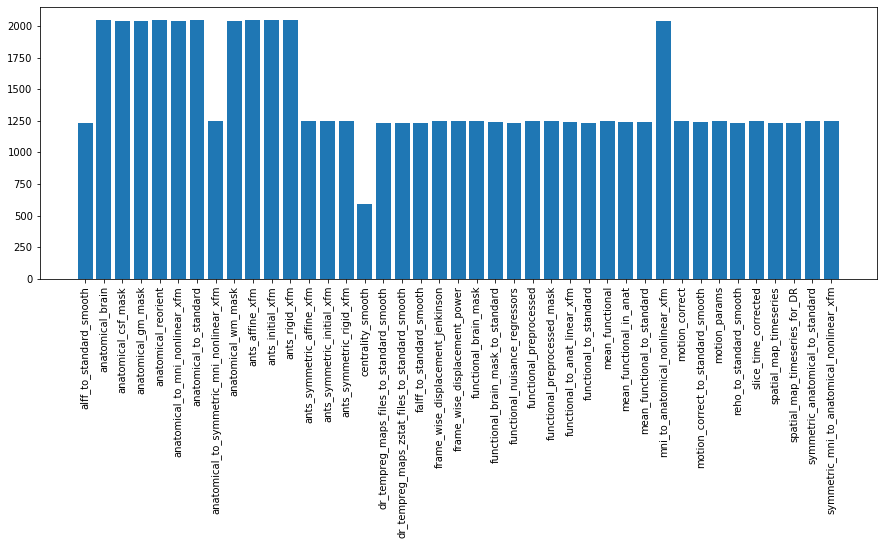

In [158]:
import matplotlib.pyplot as plt

x = list(sorted(derivs.keys()))
y = [len(set(derivs.get(k, []))) for k in sorted(derivs.keys())]

plt.figure(figsize=(15,5))
plt.bar(x, y)
plt.tick_params(axis='x', which='major')
plt.xticks(rotation=90)
plt.show()

In [165]:
with open('derivs.pkl', 'wb') as f:
    pickle.dump(derivs, f)